In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

In [23]:
iris = load_iris()
x = iris['data']
y = iris['target'] 
print('訓練資料 : {}'.format(x.shape))
print('標籤 : {}'.format(np.unique(y)))

## 拆成訓練與測試集
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

訓練資料 : (150, 4)
標籤 : [0 1 2]


### 判斷是否有GPU可以使用

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 模型搭建

In [5]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [6]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [12]:
model = Model(input_dimention=4,output_classes=3).to(device)

In [13]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 4])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([3, 32])
output.linear.bias torch.Size([3])


In [14]:
batch_size = 4
input_features = 4
dummy_input = torch.randn(batch_size, input_features).to(device)


In [15]:
output = model(dummy_input)
print(output)

tensor([[ 0.2689,  1.0266, -0.0182],
        [ 0.4221,  0.3312, -1.0611],
        [ 0.5758,  0.7022, -0.2091],
        [-0.5158,  0.2430, -1.0094]], grad_fn=<AddmmBackward>)


## Loss

#### classification

In [16]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [17]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [18]:
criterion = CrossEntropyLoss()

## optimizer

In [19]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [20]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [24]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [25]:
batch_size = 4
epochs = 400
whole_batch = np.linspace(0, len(x_train), len(x_train)//batch_size+1).astype(np.uint8)[:-1]
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

In [26]:
whole_batch

array([  0,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
        52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100,
       104, 108], dtype=uint8)

### 訓練

In [17]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in whole_batch:
        x = x_train[batch : batch+batch_size,:]
        y = y_train[batch : batch+batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 50 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 1.10
目前 test loss : 1.00
目前 test accuracy : 0.58
epoch : 50
目前 train loss : 0.56
目前 test loss : 0.35
目前 test accuracy : 0.97
epoch : 100
目前 train loss : 0.49
目前 test loss : 0.33
目前 test accuracy : 0.95
epoch : 150
目前 train loss : 0.55
目前 test loss : 0.33
目前 test accuracy : 0.97
epoch : 200
目前 train loss : 0.50
目前 test loss : 0.26
目前 test accuracy : 0.97
epoch : 250
目前 train loss : 0.58
目前 test loss : 0.28
目前 test accuracy : 0.97
epoch : 300
目前 train loss : 0.47
目前 test loss : 0.26
目前 test accuracy : 0.95
epoch : 350
目前 train loss : 0.40
目前 test loss : 0.26
目前 test accuracy : 0.97


In [18]:
print(classification_report(prediction, y_test_numpy))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38



In [23]:
test_loss_

[1.0046908855438232,
 0.8303958773612976,
 0.7702078819274902,
 0.7341659069061279,
 0.6715507507324219,
 0.6591964364051819,
 0.6304298639297485,
 0.5978138446807861,
 0.6030004620552063,
 0.5634738802909851,
 0.487557053565979,
 0.5316038131713867,
 0.5068303346633911,
 0.49855202436447144,
 0.46888467669487,
 0.4912347197532654,
 0.5023918151855469,
 0.465431272983551,
 0.4757929742336273,
 0.43491730093955994,
 0.41133052110671997,
 0.40299978852272034,
 0.43025559186935425,
 0.39655789732933044,
 0.3896576762199402,
 0.4044020473957062,
 0.3756085932254791,
 0.4131154716014862,
 0.34258517622947693,
 0.3775673806667328,
 0.3647645115852356,
 0.36804911494255066,
 0.35811781883239746,
 0.3692902624607086,
 0.3730541169643402,
 0.3565485179424286,
 0.3624030649662018,
 0.3888057768344879,
 0.3832980990409851,
 0.37305283546447754,
 0.37546277046203613,
 0.3692947328090668,
 0.3765681982040405,
 0.35464516282081604,
 0.3577636182308197,
 0.3324684500694275,
 0.33422863483428955,
 0.3

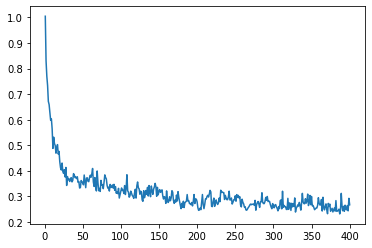

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

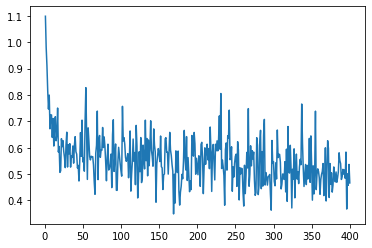

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [19]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)

### 載入 

In [29]:
checkpoint

{'epoch': 399,
 'model_state_dict': OrderedDict([('layer1.linear.0.weight',
               tensor([[-0.0216,  0.1463, -0.1414,  0.3203],
                       [ 0.2582, -0.1290,  0.2693,  0.1843],
                       [-0.4356, -0.0832,  0.2997,  0.5360],
                       [-0.1099, -0.0674,  0.2586,  0.4623],
                       [-0.3413, -0.3657,  0.3852,  0.2631],
                       [ 0.3129, -0.8004, -0.2307,  0.2443],
                       [ 0.3944, -0.3748, -0.5579, -0.2772],
                       [-0.3843, -0.2073,  0.3478, -0.2499],
                       [ 0.5854, -0.1178, -0.3538, -0.1243],
                       [-0.2909,  0.0676,  0.0553, -0.4825],
                       [-0.0650, -0.4588, -0.3941, -0.5111],
                       [ 0.0717, -0.4427, -0.4026, -0.1095],
                       [-0.0303,  0.1478, -0.0934, -0.3983],
                       [ 0.3004, -0.2886, -0.5604, -0.4444],
                       [-0.0793,  0.3794, -0.1268,  0.2365],
         

In [28]:
model = Model(input_dimention=4,output_classes=3).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
print('loading successfully...')

model.eval()
output = model(x_test)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()
test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
print(test_accuracy)

loading successfully...
1.0


### 進階儲存
* 以字典的型式存入各種資料

In [21]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': loss_test,
            }, saving_location)

### 載入 

In [22]:
##載入訓練好的 weight

model = Model(input_dimention=4,output_classes=3).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['model_state_dict'])
print('loading successfully...')
print('current loss : {}'.format(checkpoint['loss']))

model.eval()
output = model(x_test)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()
test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
print(test_accuracy)



loading successfully...
current loss : 0.2670576572418213
1.0
